Purpose: To investigate what fraction of the PHAs (or NEOs) might be discovered before or during LSST operations by other telescope, and then add these to LSST's total to see the effect of LSST + previous discoveries. 

As we use synthetic model populations (not actual populations) and do not know the survey pointing history for previous surveys, we simulate what would have been "previously discovered" by taking our model population and identifying a V magnitude threshhold which matches approximately what is known now or what will be known at the start of LSST operations. 

As a proxy for simulating the entire population + pointing histories for existing surveys, we can assume that all NEOs larger than 140m which get brighter than a given V magnitude threshhold will be discovered. Spacewatch has been in operation since 1984, CSS has been a considerable influence in NEO discovery since 2005, etc. According to the JPL NEO discovery page (http://neo.jpl.nasa.gov/stats/) we could estimate conservatively that discovery of 140m NEOs started in earnest in 2000 -- implying (a conservative) 15 years to reach the current 25% level (and the discovery rate of 140m and larger NEOs seems roughly constant over that time period, with a recent uptick of about 20% per year).  GMS16 (https://arxiv.org/pdf/1604.03444v1.pdf) indicates that the current completeness of NEOs larger than 140m is about 25% (Mainzer et al 2011) and is expected to be 43% when LSST comes online.

Thus we take our sample of NEOs, integrate their orbits over 15 years (generating ephemerides once per night), and look at their peak brightness over that time period. We then choose a peak brightness threshhold that corresponds to detecting 25% of the total NEOs larger than 140m (H=22). 

After going through the process shown in the cells below, I find the threshhold should be V=20.0 to match current completeness after 15 years of operations, and that the expected completeness if this same rate continues should be 30% at the start of LSST. However, new assets online (such as PanSTARRS) mean that the limiting magnitude should be adjusted to a fainter limit: we use V=22 as a default.

In [1]:
# Set up basics.
import os 
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Set up MAF
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.plots as plots
import lsst.sims.maf.db as db
import lsst.sims.maf.metricBundles as mmb
import lsst.sims.maf.utils as utils
import lsst.sims.maf.batches as batches

import sys
try:
    # remove a conflict on my personal system
    sys.path.remove('/Users/lynnej/work/lsst')
except ValueError:
    pass
sys.path.append(os.path.join(os.getenv('SIMS_MAF_DIR'), 'bin.src'))
#import movingObjects as moO

Set up some basic information that we need to define orbit parameters and metric ranges.

In [3]:
orbitFile = {}
orbitFile['pha'] = 'orbits/pha_2k'
orbitFile['neo'] = 'orbits/neo_5k'

In [4]:
Hmark = 22
#Hrange = np.arange(11, 28.5, 0.5)
Hrange = np.arange(14, 28.1, 0.2)
Hidx = np.where(Hrange == 22)[0]
outDir = 'other_telescopes_5k_.2'
if not (os.path.isdir(outDir)):
    os.makedirs(outDir)

If this notebook was previously run, or you have the information available, you can read back in the previous evaluation of the peak magnitudes and time of 'discovery' (first time V>20.0) for the 15 years from start of surveys to now, the 22 years from start of surveys to start of LSST, and the same information during the LSST survey.

In [5]:
# Read previously calculated times of discovery for LSST, for the 15 years up to 'now', for the 22 years between 
# now and LSST start, for the 10 years of LSST (for other resources) and the times of discovery for LSST back from disk

# Set up the moving object slicers for each of these ephemeride files. -- without obs data.
slicerEphsN =  {}
for t in ['neo', 'pha']:
    slicerEphsN[t] = batches.setupMoSlicer(orbitFile[t], Hrange, obsFile=None)

In [16]:
import pandas as pd
def readMetricValues(bundle, tmpdir):
    # For reading old h5 files:
    filename = os.path.join(tmpdir, bundle.fileRoot + '.h5')
    slicer = slicers.MoObjSlicer()
    df = pd.read_hdf(filename, 'df_with_missing')
    slicer.Hrange = df.columns.values
    slicer.slicePoints['H'] = slicer.Hrange
    slicer.shape = [len(df.values), len(slicer.Hrange)]
    slicer.orbits = None
    metricValues = ma.MaskedArray(data=df.values,
                                  mask=np.zeros(slicer.shape, 'bool'),
                                  fill_value=slicer.badval)
    try:
        metricValues.mask = np.where(np.isnan(df.values), 1, 0)
    except TypeError:
        warnings.warn('Could not mask metricValues, as they are complex type.')
    bundle.metricValues = metricValues
    bundle.metricValues.fill_value = 0
    bundle.slicer = slicer
    return bundle

In [17]:
import os
flist = os.listdir(outDir)
knownBundle = {}
peakVBundle = {}
m1 = metrics.KnownObjectsMetric()
m2 = metrics.PeakVMagMetric()
for tp in ['neo', 'pha']:
    knownBundle[tp] = {}
    for i in [0, 1, 2, 3]:
        knownBundle[tp][i] = mmb.MoMetricBundle(m1, slicerEphsN[t], None, 
                                                runName="Previously known %d" % i, metadata=t)
        froot = 'Previously_known_%d_KnownObjects_%s_MOOB' % (i, tp)
        knownBundle[tp][i].fileRoot = froot
        readMetricValues(knownBundle[tp][i], outDir)
    peakVBundle[tp] = mmb.MoMetricBundle(m2, slicerEphsN[t], None, runName="Previously Known", metadata=t)
    froot = 'PeakVMag_PeakVMag_%s_MOOB' % (tp)
    peakVBundle[tp].fileRoot = froot
    readMetricValues(peakVBundle[tp], outDir)

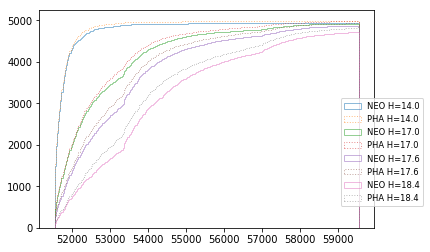

In [18]:
t = np.arange(51544., 59580., 30.)
t1 = knownBundle['neo'][0].metricValues.swapaxes(0, 1)
t2 = knownBundle['pha'][0].metricValues.swapaxes(0, 1)
for Hidx in [0, 15, 18, 22]:
    n, b, p = plt.hist(t1[Hidx].compressed(), bins=t, cumulative=True, alpha=0.5, 
                       histtype='step', label='NEO H=%.1f' % Hrange[Hidx])
    n, b, p = plt.hist(t2[Hidx].compressed(), bins=t, cumulative=True, alpha=0.5, 
                       histtype='step', linestyle=':', label='PHA H=%.1f' % Hrange[Hidx])
plt.legend(loc=(0.9, 0.1), fontsize='small')
#plt.ylim(0, 2000)

In [331]:
try:
    del metrics.BaseMetric.registry['__main__.MoTotalAtTimeMetric']
except:
     pass
    
    
class MoTotalAtTimeMetric(metrics.BaseMoMetric):
    """Calculate the total number of objects discovered as a function of time, given the times of each discovery.
    Input values of the discovery times can come from the Discovery_Time (child) metric or the
    KnownObjects metric.
    
    Parameters
    ----------
    times : numpy.ndarray like
        The bins to distribute the discovery times into. Same units as the discovery time (typically MJD).
    Ntotal : float, opt
        Normalization value for total population (cumulative # with H<=MagRef). Default 960 (for NEOs).
    MagRef : float, opt
        Magnitude at which normalization of population applies (M_o). Default 18 (for NEOs).
    Hindex : float, opt
        Use Hindex as the power law to integrate over H, if cumulative is True. Default 0.33.
    """

    def __init__(self, times, Ntotal=960, MagRef=18, Hindex=0.35, **kwargs):
        super().__init__(**kwargs)
        self.times = times
        self.Ntotal = Ntotal
        self.MagRef = MagRef
        self.Hindex = Hindex

    def run(self, discoveryTimes, Hvals):
        if len(Hvals) != discoveryTimes.shape[1]:
            warnings.warn("This summary metric expects cloned H distribution. Cannot calculate summary.")
            return
        nSsos = discoveryTimes.shape[0]
        timesinH = discoveryTimes.swapaxes(0, 1)
        completenessH = np.empty([len(Hvals), len(self.times)], float)
        for i, H in enumerate(Hvals):
            n, b = np.histogram(timesinH[i].compressed(), bins=self.times)
            completenessH[i][0] = 0
            completenessH[i][1:] = n.cumsum()
        completenessH = completenessH / float(nSsos)
        # Add extension to very bright objects.
        Hbinsize = np.unique(np.diff(Hvals))[0]
        Hextension = np.arange(Hvals.min() - 5, Hvals.min() - Hbinsize/2.0, Hbinsize)
        extendedHvals = np.concatenate([Hextension, Hvals])
        completenessExtension = np.ones((len(Hextension), len(times)), float) * completenessH.max()
        extendedCompleteness = np.concatenate([completenessExtension, completenessH], axis=0)
        # Calculate the differential number distribution as a function of H.
        Hmid = np.concatenate([extendedHvals - Hbinsize/2.0, np.array([Hvals.max() + Hbinsize/2.0])])
        totalN_H = self.Ntotal * np.power(10., self.Hindex * (Hmid - self.MagRef))
        diffN_H = totalN_H[1:] - totalN_H[:-1]
        # To save metric value, should pick out single number .. for now ok.
        summaryVal = np.empty((len(times), len(diffN_H)), dtype=[('name', np.str_, 20), ('value', float), 
                                                                 ('meta', float)])
        #summaryVal['value'] = totalFound
        for i, time in enumerate(self.times):
            totalFound = (diffN_H * extendedCompleteness[:,i]).cumsum()
            summaryVal['value'][i] = totalFound
            summaryVal['name'][i] = 'Total @ %.2f' % (time)
            summaryVal['meta'][i] = extendedHvals
        return summaryVal

In [332]:
times = np.arange(51544, 65055+15, 30)
summaryMetric = metrics.MoCompletenessAtTimeMetric(times=times, Hindex=0.33, Hval=22)
summaryMetric2 = MoTotalAtTimeMetric(times=times)

for t in ['neo', 'pha']:
    for i in (0, 1, 2, 3):
        knownBundle[t][i].setSummaryMetrics(summaryMetric2)
        knownBundle[t][i].computeSummaryStats()

In [72]:
# Actual rate from CNEOS page (NEA-140m and larger)
import pandas as pd
import datetime
cneos_data = pd.read_table('actual_rate_cneos.dat', delim_whitespace=True)
neo140rate = cneos_data['NEA140'] / 25000.0
cneos_data['pha'] = neo140rate
cneos_data['Date'] = pd.to_datetime(cneos_data.Date)
d = cneos_data.query('Date > 2000')
t2015 = pd.to_datetime(['2015-01-01'])
dyrs = (cneos_data.Date - t2015[0]) / datetime.timedelta(days=365.25) + 2015

In [138]:
cneos_data[0:3]

,Date,NEC,Atira,Aten,Apollo,Amor,PHA-KM,PHA,NEA-KM,NEA140,NEA,NEO,pha
0,2017-10-11,106,16,1235,9108,6418,157,1846,884,7845,16777,16883,0.31380
1,2017-10-01,106,16,1232,9089,6411,157,1844,884,7839,16748,16854,0.31356
2,2017-09-01,106,16,1217,8980,6299,157,1834,884,7785,16512,16618,0.31140


Eff 5\%, 60 deg, bump 10\% [ 0.31009299] [ 0.44852319] [ 0.58927443]
Eff 5\%, 100 deg, bump 10\% [ 0.29091065] [ 0.42402978] [ 0.56485942]
Eff 5\%, 100 deg, bump 22.2 + 10\% [ 0.29257017] [ 0.42470621] [ 0.58860662]
Eff 5\%, 100 deg, bump 22.2 + 20\% [ 0.2914744] [ 0.42404171] [ 0.59562212]


Text(0.5,1,'Cumulative completeness for NEO with $H<22$')

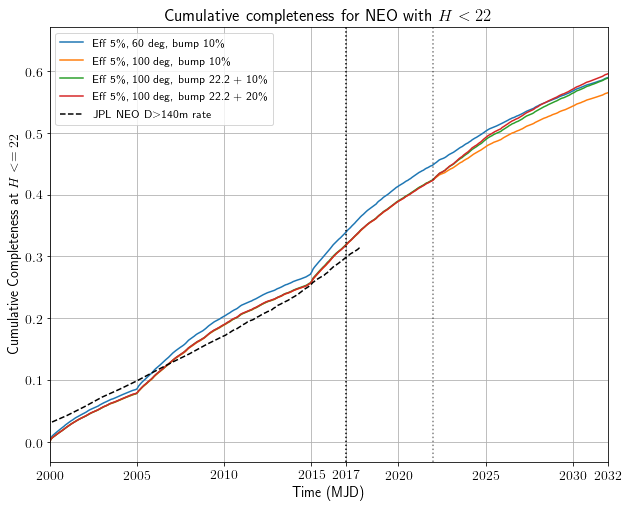

In [73]:
plt.figure(figsize=(10,8))
plt.rc('text', usetex=True)      
plt.rc('font', size=14)
years = (times - 57023) / 365.25 + 2015
for kb, bundleNum in zip((knownBundle['neo'][0], knownBundle['neo'][1], knownBundle['neo'][2], knownBundle['neo'][3]), 
                    ('Eff 5\%, 60 deg, bump 10\%', 'Eff 5\%, 100 deg, bump 10\%', 
                     'Eff 5\%, 100 deg, bump 22.2 + 10\%',  'Eff 5\%, 100 deg, bump 22.2 + 20\%')):
    comp = np.zeros(len(times), float)
    for i, t in enumerate(times):
        comp[i] = kb.summaryValues['CumulativeCompleteness@Time'][i][1]
    plt.plot(years, comp, label=r'%s' % (bundleNum))
    #plt.plot(years, comp*0.6, linestyle=':')
    idx2016 = np.where(np.abs(times - 57388) == np.abs(times - 57388).min())
    idx2022 = np.where(np.abs(times - 59580) == np.abs(times - 59580).min())
    idx2032 = np.where(np.abs(times - 63232) == np.abs(times - 63232).min())
    print(bundleNum, comp[idx2016], comp[idx2022], comp[idx2032])
plt.plot(dyrs, neo140rate, color='k', linestyle='--', label=r'JPL NEO D$>$140m rate')
plt.xlim(2000, 2032)
plt.xticks([2000, 2005, 2010, 2015, 2017, 2020, 2025, 2030, 2032])
#plt.ylim(0, 0.5)
plt.legend(loc='upper left', fancybox=True, fontsize='smaller', numpoints=1)
plt.xlabel('Time (MJD)')
plt.ylabel('Cumulative Completeness at $H<=22$')
plt.axvline(2017, color='k', linestyle=':')
plt.axvline(2022, color='k', linestyle=':', alpha=0.5)
#plt.axvline(2032, color='k', linestyle=':', alpha=0.5)
plt.grid(True)
plt.title('Cumulative completeness for NEO with $H<22$')


[ 0.29257017] [ 0.42470621] [ 0.58860662]


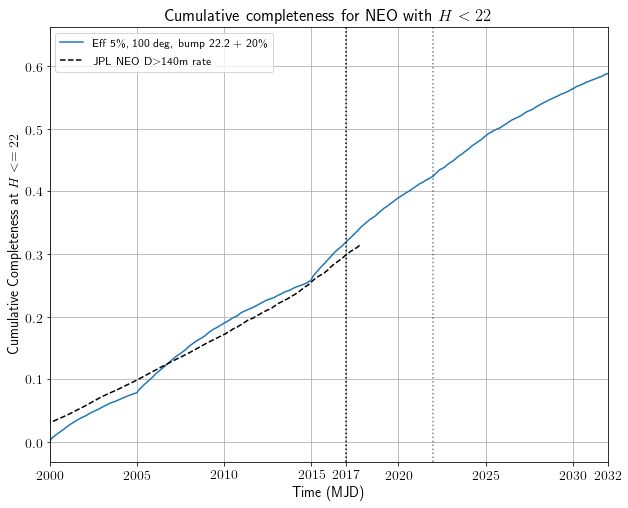

In [74]:
plt.figure(figsize=(10,8))
plt.rc('text', usetex=True)      
plt.rc('font', size=14)
years = (times - 57023) / 365.25 + 2015
kb = knownBundle['neo'][2]
comp = np.zeros(len(times), float)
for i, t in enumerate(times):
    comp[i] = kb.summaryValues['CumulativeCompleteness@Time'][i][1]
plt.plot(years, comp, label=r'%s' % (bundleNum))
#plt.plot(years, comp*0.6, linestyle=':')
idx2016 = np.where(np.abs(times - 57388) == np.abs(times - 57388).min())
idx2022 = np.where(np.abs(times - 59580) == np.abs(times - 59580).min())
idx2032 = np.where(np.abs(times - 63232) == np.abs(times - 63232).min())
print(comp[idx2016], comp[idx2022], comp[idx2032])
plt.plot(dyrs, neo140rate, color='k', linestyle='--', label=r'JPL NEO D$>$140m rate')
plt.xlim(2000, 2032)
plt.xticks([2000, 2005, 2010, 2015, 2017, 2020, 2025, 2030, 2032])
#plt.ylim(0, 0.5)
plt.legend(loc='upper left', fancybox=True, fontsize='smaller', numpoints=1)
plt.xlabel('Time (MJD)')
plt.ylabel('Cumulative Completeness at $H<=22$')
plt.axvline(2017, color='k', linestyle=':')
plt.axvline(2022, color='k', linestyle=':', alpha=0.5)
#plt.axvline(2032, color='k', linestyle=':', alpha=0.5)
plt.grid(True)
plt.title('Cumulative completeness for NEO with $H<22$')
plt.savefig('other_surveys_completeness.pdf', format='pdf')
known = {}
known['neo'] = knownBundle['neo'][2]
known['pha'] = knownBundle['pha'][2]

In [322]:
jpl_yearly = pd.read_csv('../jpl_discovery_stats.csv')
jpl_yearly_140m = pd.read_csv('../jpl_discovery_140m.csv')
jpl_yearly_140m[0:3]

,Year,LINEAR,NEAT,Spacewatch,LONEOS,Catalina,Pan-STARRS,NEOWISE,ATLAS,All others,TOTAL
0,2018,0,0,0,0,131,121,12,13,10,287
1,2017,11,0,0,0,180,277,22,38,11,539
2,2016,24,0,1,0,177,310,25,9,19,565


9285.28865842


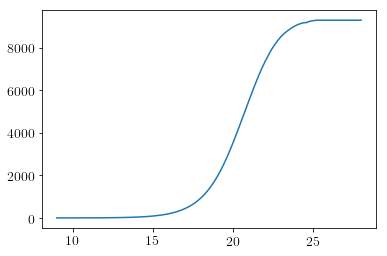

In [334]:
idx2016 = np.where(np.abs(times - 57388) == np.abs(times - 57388).min())
plt.plot(kb.summaryValues['MoTotalAtTime'][195]['meta'], kb.summaryValues['MoTotalAtTime'][195]['value'])
print(kb.summaryValues['MoTotalAtTime'][195]['value'][-1])

[ 7337.70312277] [ 10787.70218749] [ 15127.69672706]


Text(0.5,1,'Total number of NEOs')

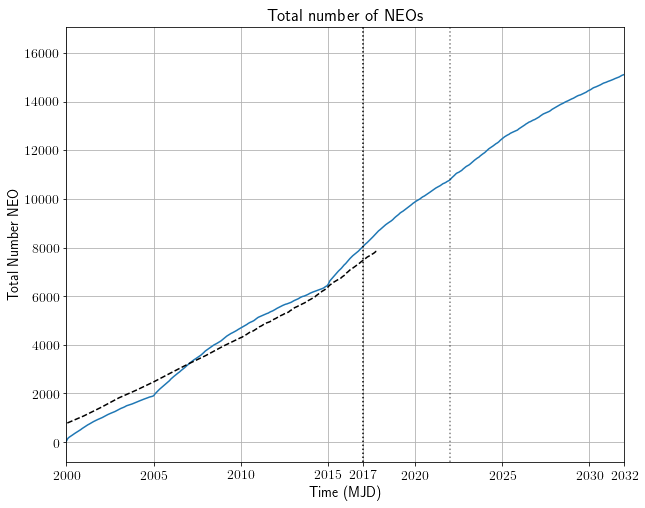

In [335]:
plt.figure(figsize=(10,8))
plt.rc('text', usetex=True)      
plt.rc('font', size=14)
years = (times - 57023) / 365.25 + 2015
kb = knownBundle['neo'][2]
tot = np.zeros(len(times), float)
Hidx = np.where(abs(kb.summaryValues['MoTotalAtTime'][0]['meta'] - 22) == 
                abs(kb.summaryValues['MoTotalAtTime'][0]['meta'] - 22).min())[0]
#Hidx = -1
for i, t in enumerate(times):
    tot[i] = kb.summaryValues['MoTotalAtTime'][i]['value'][Hidx]
plt.plot(years, tot, label=r'%s' % (bundleNum))
idx2016 = np.where(np.abs(times - 57388) == np.abs(times - 57388).min())
idx2022 = np.where(np.abs(times - 59580) == np.abs(times - 59580).min())
idx2032 = np.where(np.abs(times - 63232) == np.abs(times - 63232).min())
print(tot[idx2016], tot[idx2022], tot[idx2032])
plt.plot(dyrs, cneos_data.NEA140, color='k', linestyle='--', label=r'JPL total NEO')
plt.xlim(2000, 2032)
plt.xticks([2000, 2005, 2010, 2015, 2017, 2020, 2025, 2030, 2032])
#plt.ylim(0, 0.5)
#plt.legend(loc='upper left', fancybox=True, fontsize='smaller', numpoints=1)
plt.xlabel('Time (MJD)')
plt.ylabel('Total Number NEO')
plt.axvline(2017, color='k', linestyle=':')
plt.axvline(2022, color='k', linestyle=':', alpha=0.5)
#plt.axvline(2032, color='k', linestyle=':', alpha=0.5)
plt.grid(True)
plt.title('Total number of NEOs')

[ 11783.97664939  10495.92005005   9285.28865842   7866.81170838
   7257.90148437   6834.57577079   6412.62193858   5944.40704488
   5404.50124045   4846.78495594   4169.58895154   3490.30463081
   2802.64460924   2009.50676897   1729.16880787   1416.192653
   1002.28867341    598.40142879     33.16369467     33.16369467
     33.16369467     33.16369467     33.16369467     33.16369467]


Text(0.5,1,'Total number of NEOs')

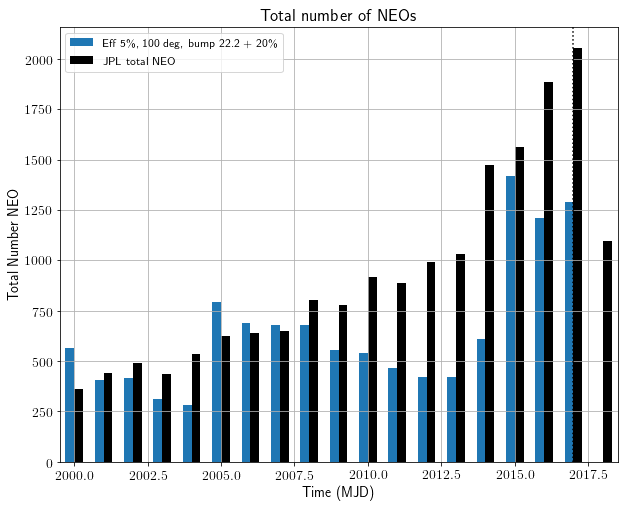

In [336]:
plt.figure(figsize=(10,8))
plt.rc('text', usetex=True)      
plt.rc('font', size=14)
years = (times - 57023) / 365.25 + 2015
kb = knownBundle['neo'][2]
tot = np.zeros(len(jpl_yearly.Year), float)
for i, yr in enumerate(jpl_yearly.Year):
    idx = np.where(np.abs(years - yr) == np.abs(years - yr).min())[0]
    tot[i] = kb.summaryValues['MoTotalAtTime']['value'][idx][0][-1]
plt.bar(jpl_yearly.Year[1:]-0.15, tot[:-1] - tot[1:], width=0.3, label=r'%s' % (bundleNum))
print(tot)
#idx2016 = np.where(np.abs(times - 57388) == np.abs(times - 57388).min())
#idx2022 = np.where(np.abs(times - 59580) == np.abs(times - 59580).min())
#idx2032 = np.where(np.abs(times - 63232) == np.abs(times - 63232).min())
#print(tot[idx2016], tot[idx2022], tot[idx2032])
plt.bar(jpl_yearly.Year+0.15, jpl_yearly.TOTAL, color='k', width=0.3, linestyle='--', label=r'JPL total NEO')
plt.xlim(1999.5, 2018.5)
#plt.xticks([2000, 2005, 2010, 2015, 2017, 2020, 2025, 2030, 2032])
#plt.ylim(0, 200)
plt.legend(loc='upper left', fancybox=True, fontsize='smaller', numpoints=1)
plt.xlabel('Time (MJD)')
plt.ylabel('Total Number NEO')
plt.axvline(2017, color='k', linestyle=':')
plt.axvline(2022, color='k', linestyle=':', alpha=0.5)
#plt.axvline(2032, color='k', linestyle=':', alpha=0.5)
plt.grid(True)
plt.title('Total number of NEOs')

Text(0.5,1,'Total number of NEOs with D$>$140m/H=22')

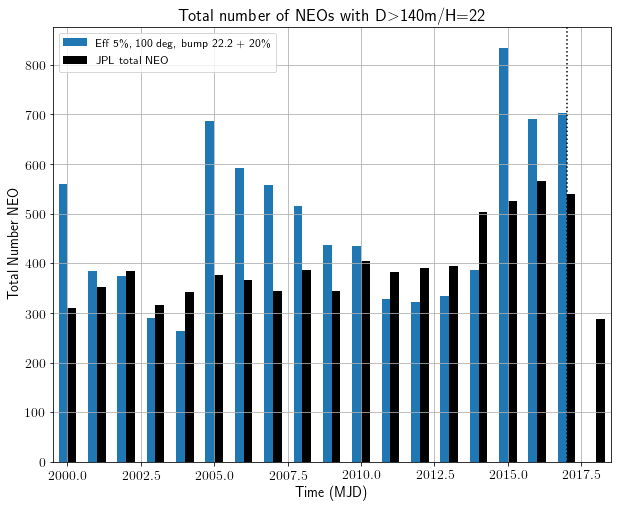

In [340]:
plt.figure(figsize=(10,8))
plt.rc('text', usetex=True)      
plt.rc('font', size=14)
years = (times - 57023) / 365.25 + 2015
kb = knownBundle['neo'][2]
tot = np.zeros(len(jpl_yearly.Year), float)

for i, yr in enumerate(jpl_yearly.Year):
    idx = np.where(np.abs(years - yr) == np.abs(years - yr).min())[0]
    tot[i] = kb.summaryValues['MoTotalAtTime']['value'][idx][0][Hidx]
plt.bar(jpl_yearly.Year[1:]-0.15, tot[:-1] - tot[1:], width=0.3, label=r'%s' % (bundleNum))
#idx2016 = np.where(np.abs(times - 57388) == np.abs(times - 57388).min())
#idx2022 = np.where(np.abs(times - 59580) == np.abs(times - 59580).min())
#idx2032 = np.where(np.abs(times - 63232) == np.abs(times - 63232).min())
#print(tot[idx2016], tot[idx2022], tot[idx2032])
plt.bar(jpl_yearly.Year+0.15, jpl_yearly_140m.TOTAL, color='k', width=0.3, linestyle='--', label=r'JPL total NEO')
plt.xlim(1999.5, 2018.5)
#plt.xticks([2000, 2005, 2010, 2015, 2017, 2020, 2025, 2030, 2032])
#plt.ylim(0, 200)
plt.legend(loc='upper left', fancybox=True, fontsize='smaller', numpoints=1)
plt.xlabel('Time (MJD)')
plt.ylabel('Total Number NEO')
plt.axvline(2017, color='k', linestyle=':')
plt.axvline(2022, color='k', linestyle=':', alpha=0.5)
#plt.axvline(2032, color='k', linestyle=':', alpha=0.5)
plt.grid(True)
plt.title('Total number of NEOs with D$>$140m/H=22')

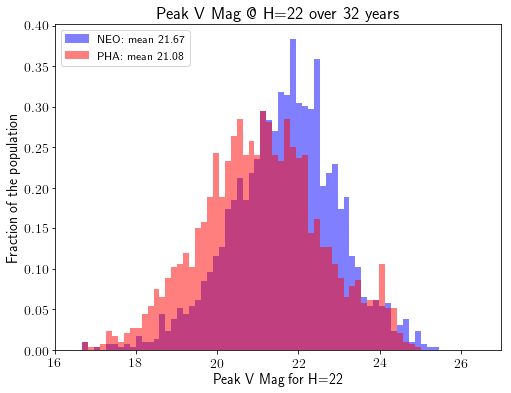

In [225]:
# Just a plot to show why completeness different for neos vs phas
Hidx = np.where(np.abs(Hrange-22) == np.abs(Hrange-22).min())[0]
lpha = np.swapaxes(peakVBundle['pha'].metricValues, 0, 1)[Hidx][0]
lneo = np.swapaxes(peakVBundle['neo'].metricValues, 0, 1)[Hidx][0]

plt.figure(figsize=(8, 6))
meanV = np.mean(lneo)
n, b, p = plt.hist(lneo, bins=60, normed=True, color='b', alpha=0.5, label='NEO: mean %.2f' % meanV)
meanV = np.mean(lpha)
n, b, p = plt.hist(lpha, bins=b, normed=True, color='r', alpha=0.5, label='PHA: mean %.2f' % meanV)
plt.xlim(16, 27)
plt.legend(loc='upper left', fontsize='smaller')
plt.title('Peak V Mag @ H=22 over 32 years')
plt.xlabel('Peak V Mag for H=22')
plt.ylabel('Fraction of the population')
plt.savefig('prev_peakVmag.pdf')

So that tells us about what could have been discovered prior to LSST (and at the present time). 

Now let's look at what LSST would have found, with our more realistic discovery criteria (3 nights of pairs, within 30 days).  Read the discovery times data back from disk.

In [271]:
opsims = ['minion_1016', 'astro_lsst_01_1016', 'astro_lsst_01_1015', 'astro_lsst_01_1017', 'astro-lsst-01_2013']
opsims = ['minion_1016']
opsims = ['astro_lsst_01_1016'] 

maxYears = 12
nyears = np.arange(2, maxYears+1, 2)
nyears = np.concatenate([[1], nyears])
if maxYears not in nyears:
    nyears = np.concatenate([nyears, [maxYears]])

# Read from disk.
mtmp = metrics.DiscoveryMetric(nObsPerNight=2, tMin=0, tMax=90./60./24., nNightsPerWindow=3, tWindow=30)
metric = metrics.Discovery_TimeMetric(mtmp)
timebundles = {}
strategies = ['3 pairs in 12 nights', '3 pairs in 15 nights', '3 pairs in 20 nights', 
            '3 pairs in 25 nights', '3 pairs in 30 nights', '4 pairs in 20 nights']
#strategies += ['3 pairs in 15 nights trailing loss', '3 pairs in 30 nights trailing loss']
#strategies += ['3 pairs in 15 nights SNReq4', '3 pairs in 30 nights SNReq4']
#strategies += ['3 pairs in 15 nights trailing loss SNReq4', '3 pairs in 30 nights trailing loss SNReq4']
#strategies += ['Single detection', 'Single pair']
#strategies += ['3 pairs in 15 nights SNReq0']
#strategies += ['6 detections in 60 nights yr 10']
strategies = [s + ' detection loss' for s in strategies]


types = ['neo', 'pha']
for opsim in opsims:
    timebundles[opsim] = {}
    for t in types:
        # ddir = 'discovery'
        # ddir = 'newsky/%s_%s' % (opsim, t)
        ddir = '%s_%s' % (opsim, t)
        timebundles[opsim][t] = {}
        for strategy in strategies:
            timebundles[opsim][t][strategy] = mmb.MoMetricBundle(metric, slicerEphsN[t], None, 
                                                                 runName=opsim, metadata=t)
            nk = '%s_5k' % t
            #nk = t.upper()
            froot = '%s_Discovery_Time_%s_%s_MOOB' % (opsim, nk, strategy.replace(' ', '_'))
            if strategy == '6 detections in 60 nights yr 10':
                froot = '%s_MagicDiscovery_%s_%s_MOOB' % (opsim, nk, strategy.replace(' ', '_'))
            timebundles[opsim][t][strategy].fileRoot = froot
            readMetricValues(timebundles[opsim][t][strategy], ddir) 

No handles with labels found to put in legend.


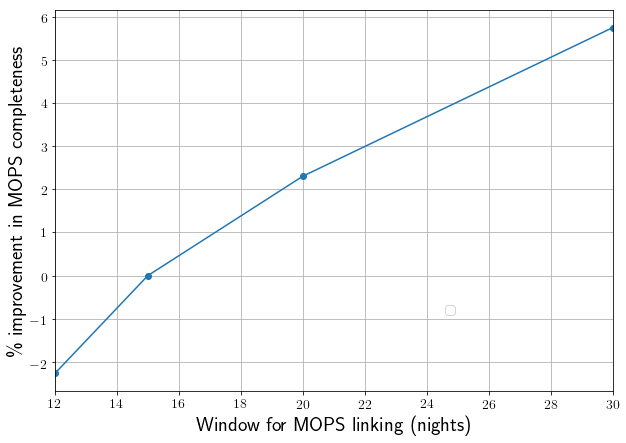

In [226]:
times = np.arange(59580.16, 63232.16, 30)
completenessSummary = [metrics.MoCompletenessAtTimeMetric(times, cumulative=True, Hval=22)]
plt.figure(figsize=(10, 7))
windows = np.array([12, 15, 20, 30])
for opsim in opsims:
    comp = np.zeros(len(windows), float)
    for i, window in enumerate(windows):
        strat = '3 pairs in %d nights detection loss' % (window)
        tb = timebundles[opsim]['neo'][strat]
        tb.setSummaryMetrics(completenessSummary)
        tb.computeSummaryStats()
        comp[i] = tb.summaryValues['CumulativeCompleteness@Time']['value'][-1]
        #plt.plot(times, tb.summaryValues['CumulativeCompleteness@Time']['value'], label=strat)
    plt.plot(windows, (comp-comp[1])/comp[1]*100., linestyle='-', marker='o', label=None)
plt.grid(True)
plt.xlim(12, 30)
plt.xlabel('Window for MOPS linking (nights)', fontsize='x-large')
plt.ylabel('\% improvement in MOPS completeness', fontsize='x-large')
plt.legend(loc=(.7, .2), fontsize='smaller', numpoints=1, fancybox=True)

In [227]:
Hrange2 = timebundles[opsims[0]]['neo'][strategies[0]].slicer.Hrange
if np.any(Hrange2 != kb.slicer.Hrange):
    print('no')

In [228]:
def combineTimes(discTimes1, discTimes2):
    discTimes = np.where(discTimes1.filled(100000) <= discTimes2.filled(1000000), discTimes1, discTimes2)
    mask = np.where((discTimes1.mask == True) & (discTimes2.mask == True), True, False)
    discTimes = ma.MaskedArray(data=discTimes, mask=mask, fill=-999)
    return discTimes

In [229]:
def compTime(discoveryTimes, Hvals, times, cumulative=True):
    nSsos = discoveryTimes.shape[0]
    timesinH = discoveryTimes.swapaxes(0, 1)
    completenessH = np.empty([len(Hvals), len(times)], float)
    for i, H in enumerate(Hvals):
        if len(timesinH[i].compressed()) == 0:
            completenessH[i] = np.zeros(len(times), float)
        else:
            n, b = np.histogram(timesinH[i].compressed(), bins=times)
            completenessH[i][0] = 0
            completenessH[i][1:] = n.cumsum()
    completenessH = completenessH / float(nSsos)
    completeness = completenessH.swapaxes(0, 1)
    if cumulative:
        for i, t in enumerate(times):
            completeness[i] = metrics.integrateOverH(completeness[i], Hvals, Hindex=0.33)
    return completeness

In [326]:
def totalN(discoveryTimes, Hvals, times, Hindex=0.35, MagRef=18, Ntotal=960):
    if len(Hvals) != discoveryTimes.shape[1]:
        warnings.warn("This summary metric expects cloned H distribution. Cannot calculate summary.")
        return
    nSsos = discoveryTimes.shape[0]
    timesinH = discoveryTimes.swapaxes(0, 1)
    completenessH = np.empty([len(Hvals), len(times)], float)
    for i, H in enumerate(Hvals):
        n, b = np.histogram(timesinH[i].compressed(), bins=times)
        completenessH[i][0] = 0
        completenessH[i][1:] = n.cumsum()
    completenessH = completenessH / float(nSsos)
    # Add extension to very bright objects.
    Hbinsize = np.unique(np.diff(Hvals))[0]
    Hextension = np.arange(Hvals.min() - 10, Hvals.min() - Hbinsize/2.0, Hbinsize)
    extendedHvals = np.concatenate([Hextension, Hvals])
    completenessExtension = np.ones((len(Hextension), len(times)), float) * completenessH.max()
    extendedCompleteness = np.concatenate([completenessExtension, completenessH], axis=0)
    # Calculate the differential number distribution as a function of H.
    Hmid = np.concatenate([extendedHvals - Hbinsize/2.0, np.array([Hvals.max() + Hbinsize/2.0])])
    totalN_H = Ntotal * np.power(10., Hindex * (Hmid - MagRef))
    diffN_H = totalN_H[1:] - totalN_H[:-1]
    totalFound = np.zeros((len(times), len(diffN_H)), float)
    for i, time in enumerate(times):
        totalFound[i] = (diffN_H * extendedCompleteness[:,i]).cumsum()
    return totalFound

3 pairs in 15 nights detection loss

 minion_1016
using 10 years
NEO
At 2015, have 0.257 NEO completeness from other surveys (57034.160000, 2015.030554)
At 2016, have 0.289 NEO completeness from other surveys (57394.160000, 2016.016181)
At start of LSST (2022), have 0.420 NEO completeness from other surveys (59584.160000, 2022.012074)
At 2032, have 0.581 NEO completeness from other surveys (63214.160000, 2031.950472)
Year 2031.950472
LSST only: 0.609
LSST + existing surveys: 0.7324
Year 2031.950472 (yr 10)
LSST only: 0.609
LSST + existing surveys: 0.732
PHA
At 2015, have 0.338 PHA completeness from other surveys (57034.160000, 2015.030554)
At 2016, have 0.375 PHA completeness from other surveys (57394.160000, 2016.016181)
At start of LSST (2022), have 0.517 PHA completeness from other surveys (59584.160000, 2022.012074)
At 2032, have 0.700 PHA completeness from other surveys (63214.160000, 2031.950472)
Year 2031.950472
LSST only: 0.657
LSST + existing surveys: 0.8151
Year 2031.950472 (

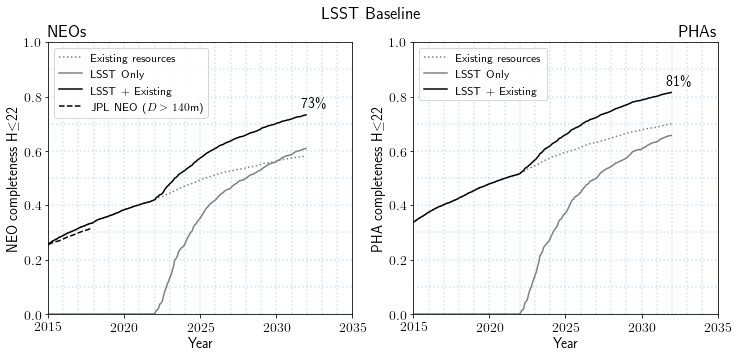

In [239]:
# Plot the cumulative completeness for H<=22 for NEOs (neo22, neo, and neo22+neo) and then PHAs
strategy = '3 pairs in 15 nights detection loss'
print(strategy)
for opsim in opsims:
    print('\n', opsim)
    #times = np.arange(51544.16, 63230.16, 120)
    times12 = np.arange(51544.16, 63963.16, 30) 
    times10 = np.arange(51544.16, 63232.16, 30)
    yrs12 = (times12 - 57023)/365.25 + 2015
    yrs10 = (times10 - 57023)/365.25 + 2015
    if opsim == 'minion_1016':
        print('using 10 years')
        yrs = yrs10
        times = times10
    else:
        print('using 12 years')
        yrs = yrs12
        times = times12
    i=0
    plt.figure(figsize=(12, 5))
    plt.rc('text', usetex=True)      
    #plt.rc('font', family='serif')
    plt.rc('font', size=14)
    for t in types:
        i+=1
        comp = {}
        comp['other'] = compTime(known[t].metricValues, Hrange2, times)
        comp['lsst'] = compTime(timebundles[opsim][t][strategy].metricValues, Hrange2, times)
        comp['both'] = compTime(combineTimes(known[t].metricValues, timebundles[opsim][t][strategy].metricValues), 
                                Hrange2, times)
        Hidx = np.where(np.abs(Hrange-22) == np.abs(Hrange-22).min())[0][0]
        endcomp = comp['both'][-1][Hidx]
        ax = plt.subplot(1,2,i)
        plt.plot(yrs, comp['other'].swapaxes(0,1)[Hidx], color='gray', linestyle=':', label='Existing resources')
        plt.plot(yrs, comp['lsst'].swapaxes(0,1)[Hidx], color='gray', linestyle="-", label='LSST Only')
        plt.plot(yrs, comp['both'].swapaxes(0,1)[Hidx], color='black', label='LSST + Existing')
        if t == 'neo':
            plt.plot(dyrs, neo140rate, color='k', linestyle='--', label=r'JPL NEO ($D>140$m)')
        plt.legend(loc='upper left', fontsize='smaller')
        # Floor here for consistency with other tables! Remove in the future.
        endcomp = np.floor(np.round(comp['both'][-1][Hidx]*1000)/10)/100
        labelheight = endcomp + 0.03
        ax.text(0.83, labelheight, r'%.0f%s' % (endcomp*100, "\%"), fontweight='heavy', transform=ax.transAxes)
        startYear = 2015
        for y in (np.arange(startYear, 2035, 1)):
            plt.axvline(y, alpha=0.2, linestyle=':')
        for i in (np.arange(0, 1.1, 0.1)):
            plt.axhline(i, alpha=0.2, linestyle=':')
        plt.xlim(startYear, 2035)
        plt.ylim(0, 1)
        plt.xlabel(r'Year')
        plt.ylabel(r'%s completeness H$\leq$22' % (t.upper()))
        if t == 'neo':
            loc = 'left'
        else:
            loc = 'right'
        plt.title(r'%ss' % (t.upper()), loc=loc)
        plt.suptitle('LSST Baseline', fontsize='large', fontweight='heavy')
        plt.savefig('neo_pha_completeness_3in15_%s.pdf' % (opsim), format='pdf')

        print(t.upper())
        idx_2015 = np.where(abs(yrs-2015) == abs(yrs-2015).min())[0][0]
        idx_2016 = np.where(abs(yrs-2016) == abs(yrs-2016).min())[0][0]
        idx_start = np.where(abs(yrs-2022) == abs(yrs-2022).min())[0][0]
        idx_2032 = np.where(abs(yrs-2032) == abs(yrs-2032).min())[0][0]
        print('At 2015, have %.3f %s completeness from other surveys (%f, %f)' %(comp['other'][idx_2015][Hidx], t.upper(), 
                                                                             times[idx_2015], yrs[idx_2015]))
        print('At 2016, have %.3f %s completeness from other surveys (%f, %f)' %(comp['other'][idx_2016][Hidx], t.upper(), 
                                                                             times[idx_2016], yrs[idx_2016]))
        print('At start of LSST (2022), have %.3f %s completeness from other surveys (%f, %f)' %(comp['other'][idx_start][Hidx], 
                                                                                             t.upper(), times[idx_start], 
                                                                                             yrs[idx_start]))
        print('At 2032, have %.3f %s completeness from other surveys (%f, %f)' %(comp['other'][idx_2032][Hidx], 
                                                                             t.upper(), times[idx_2032], yrs[idx_2032]))
        print('Year %f' %yrs[-1])
        print('LSST only: %.3f' % (comp['lsst'][-1][Hidx]))
        print('LSST + existing surveys: %.4f' % (comp['both'][-1][Hidx]))

        print('Year %f (yr 10)' %yrs[idx_2032])
        print('LSST only: %.3f' % (comp['lsst'][idx_2032][Hidx]))
        print('LSST + existing surveys: %.3f' % (comp['both'][idx_2032][Hidx]))

3 pairs in 30 nights detection loss

 astro_lsst_01_1016
using 12 years
NEO
At 2015, have 0.260 NEO completeness from other surveys (57034.160000, 2015.030554)
At 2016, have 0.293 NEO completeness from other surveys (57394.160000, 2016.016181)
At start of LSST (2022), have 0.425 NEO completeness from other surveys (59584.160000, 2022.012074)
At 2032, have 0.589 NEO completeness from other surveys (63244.160000, 2032.032608)
At 2034, have 0.607 NEO completeness from other surveys (63934.160000, 2033.921725)
Year 2033.921725
LSST only: 0.693
LSST + existing surveys: 0.772
LSST + existing surveys: 0.772
Year 2032.032608 (yr 10)
LSST only: 0.655
LSST + existing surveys: 0.747
PHA
At 2015, have 0.349 PHA completeness from other surveys (57034.160000, 2015.030554)
At 2016, have 0.385 PHA completeness from other surveys (57394.160000, 2016.016181)
At start of LSST (2022), have 0.538 PHA completeness from other surveys (59584.160000, 2022.012074)
At 2032, have 0.723 PHA completeness from other

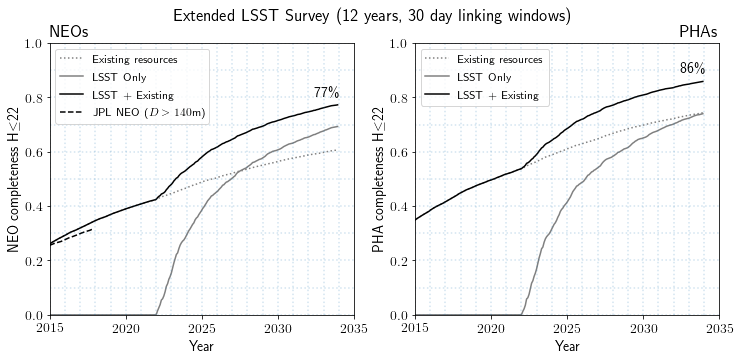

In [233]:
# Plot the cumulative completeness for H<=22 for NEOs (neo22, neo, and neo22+neo) and then PHAs
strategy = '3 pairs in 30 nights detection loss'
print(strategy)
for opsim in opsims:
    print('\n', opsim)
    #times = np.arange(51544.16, 63230.16, 120)
    times12 = np.arange(51544.16, 63963.16, 30) 
    times10 = np.arange(51544.16, 63232.16, 30)
    yrs12 = (times12 - 57023)/365.25 + 2015
    yrs10 = (times10 - 57023)/365.25 + 2015
    if opsim == 'minion_1016':
        print('using 10 years')
        yrs = yrs10
        times = times10
    else:
        print('using 12 years')
        yrs = yrs12
        times = times12
    i=0
    plt.figure(figsize=(12, 5))
    plt.rc('text', usetex=True)      
    #plt.rc('font', family='serif')
    plt.rc('font', size=14)
    for t in types:
        i+=1
        comp = {}
        comp['other'] = compTime(known[t].metricValues, Hrange2, times)
        comp['lsst'] = compTime(timebundles[opsim][t][strategy].metricValues, Hrange2, times)
        comp['both'] = compTime(combineTimes(known[t].metricValues, timebundles[opsim][t][strategy].metricValues), 
                                Hrange2, times)
        Hidx = np.where(np.abs(Hrange-22) == np.abs(Hrange-22).min())[0][0]
        ax = plt.subplot(1,2,i)
        plt.plot(yrs, comp['other'].swapaxes(0,1)[Hidx], color='gray', linestyle=':', label='Existing resources')
        plt.plot(yrs, comp['lsst'].swapaxes(0,1)[Hidx], color='gray', linestyle="-", label='LSST Only')
        plt.plot(yrs, comp['both'].swapaxes(0,1)[Hidx], color='black', label='LSST + Existing')
        if t == 'neo':
            plt.plot(dyrs, neo140rate, color='k', linestyle='--', label=r'JPL NEO ($D>140$m)')
        plt.legend(loc='upper left', fontsize='smaller')
        endcomp = comp['both'][-1][Hidx]
        labelheight = endcomp + 0.03
        ax.text(0.87, labelheight, r'%.0f%s' % (endcomp*100, "\%"), fontweight='heavy', transform=ax.transAxes)
        start_year = 2015
        for y in (np.arange(start_year, 2035, 1)):
            plt.axvline(y, alpha=0.2, linestyle=':')
        for i in (np.arange(0, 1.1, 0.1)):
            plt.axhline(i, alpha=0.2, linestyle=':')
        plt.xlim(start_year, 2035)
        plt.ylim(0, 1)
        plt.xlabel(r'Year')
        plt.ylabel(r'%s completeness H$\leq$22' % (t.upper()))
        if t == 'neo':
            loc = 'left'
        else:
            loc = 'right'
        plt.title(r'%ss' % (t.upper()), loc=loc)
        plt.suptitle('Extended LSST Survey (12 years, 30 day linking windows)', fontsize='large', fontweight='heavy')
        plt.savefig('neo_pha_completeness_3in30_%s.pdf' % (opsim), format='pdf')

        print(t.upper())
        idx_2015 = np.where(abs(yrs-2015) == abs(yrs-2015).min())[0][0]
        idx_2016 = np.where(abs(yrs-2016) == abs(yrs-2016).min())[0][0]
        idx_start = np.where(abs(yrs-2022) == abs(yrs-2022).min())[0][0]
        idx_2032 = np.where(abs(yrs-2032) == abs(yrs-2032).min())[0][0]
        idx_2034 = np.where(abs(yrs-2034) == abs(yrs-2034).min())[0][0]
        print('At 2015, have %.3f %s completeness from other surveys (%f, %f)' %(comp['other'][idx_2015][Hidx], t.upper(), 
                                                                             times[idx_2015], yrs[idx_2015]))
        print('At 2016, have %.3f %s completeness from other surveys (%f, %f)' %(comp['other'][idx_2016][Hidx], t.upper(), 
                                                                             times[idx_2016], yrs[idx_2016]))
        print('At start of LSST (2022), have %.3f %s completeness from other surveys (%f, %f)' %(comp['other'][idx_start][Hidx], 
                                                                                             t.upper(), times[idx_start], 
                                                                                             yrs[idx_start]))
        print('At 2032, have %.3f %s completeness from other surveys (%f, %f)' %(comp['other'][idx_2032][Hidx], 
                                                                             t.upper(), times[idx_2032], yrs[idx_2032]))
        print('At 2034, have %.3f %s completeness from other surveys (%f, %f)' %(comp['other'][idx_2034][Hidx], 
                                                                             t.upper(), times[idx_2034], yrs[idx_2034]))
        print('Year %f' %yrs[-1])
        print('LSST only: %.3f' % (comp['lsst'][-1][Hidx]))
        print('LSST + existing surveys: %.3f' % (comp['both'][-1][Hidx]))
        print('LSST + existing surveys: %.3f' % (comp['both'][idx_2034][Hidx]))

        print('Year %f (yr 10)' %yrs[idx_2032])
        print('LSST only: %.3f' % (comp['lsst'][idx_2032][Hidx]))
        print('LSST + existing surveys: %.3f' % (comp['both'][idx_2032][Hidx]))

3 pairs in 15 nights detection loss

 astro_lsst_01_1016
using 12 years
NEO
At 2015, have 7764.813 NEO completeness from other surveys (57022.910000, 2014.999754)
At 2016, have 9258.660 NEO completeness from other surveys (57388.160000, 2015.999754)
At start of LSST (2022), have 16129.121 NEO completeness from other surveys (59579.660000, 2021.999754)
At 2032, have 29107.757 NEO completeness from other surveys (63232.160000, 2031.999754)
Year 2033.999754
LSST only: 51727.258
LSST + existing surveys: 61637.8970
Year 2031.999754 (yr 10)
LSST only: 44838.069
LSST + existing surveys: 54894.427


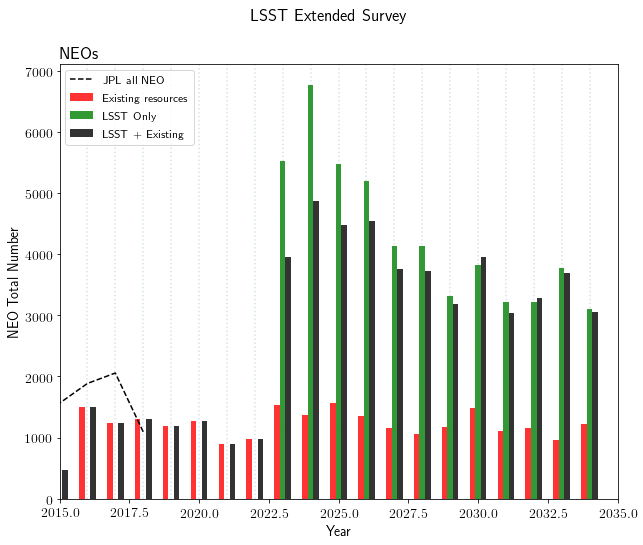

In [342]:
# Plot the cumulative completeness for H<=22 for NEOs (neo22, neo, and neo22+neo) and then PHAs
strategy = '3 pairs in 15 nights detection loss'
Hidx = -1
print(strategy)
for opsim in opsims:
    print('\n', opsim)
    #times = np.arange(51544.16, 63230.16, 120)
    times12 = np.arange(51544.16, 63963.16, 365.25) 
    times10 = np.arange(51544.16, 63232.16, 365.25)
    yrs12 = (times12 - 57023)/365.25 + 2015
    yrs10 = (times10 - 57023)/365.25 + 2015
    if opsim == 'minion_1016':
        print('using 10 years')
        yrs = yrs10
        times = times10
    else:
        print('using 12 years')
        yrs = yrs12
        times = times12
    i=0
    plt.figure(figsize=(10, 8))
    plt.rc('text', usetex=True)      
    #plt.rc('font', family='serif')
    plt.rc('font', size=14)
    for t in ['neo']:
        i+=1
        comp = {}
        comp['other'] = totalN(known[t].metricValues, Hrange2, times)
        comp['lsst'] = totalN(timebundles[opsim][t][strategy].metricValues, Hrange2, times)
        comp['both'] = totalN(combineTimes(known[t].metricValues, timebundles[opsim][t][strategy].metricValues), 
                                Hrange2, times)
        Hidx = np.where(np.abs(Hrange-22) == np.abs(Hrange-22).min())[0][0]
        Hidx = -1
        ax = plt.subplot(1,1,i)
        peryr = (comp['other'].swapaxes(0, 1)[Hidx][1:] - comp['other'].swapaxes(0, 1)[Hidx][:-1])
        plt.bar(yrs[1:]-.2, peryr, color='r',  alpha=0.8, width=0.2, label='Existing resources')
        peryr = (comp['lsst'].swapaxes(0, 1)[Hidx][1:]  - comp['lsst'].swapaxes(0, 1)[Hidx][:-1])
        plt.bar(yrs[1:]-0, peryr, color='g',  alpha=0.8, width=0.2, label='LSST Only')
        peryr = (comp['both'].swapaxes(0, 1)[Hidx][1:] - comp['both'].swapaxes(0, 1)[Hidx][:-1])
        plt.bar(yrs[1:]+0.2, peryr, color='black', alpha=0.8, width=0.2, label='LSST + Existing')
        if t == 'neo':
            plt.plot(jpl_yearly.Year, jpl_yearly.TOTAL, color='k', linestyle='--', label=r'JPL all NEO')
        plt.legend(loc='upper left', fontsize='smaller')
        # Floor here for consistency with other tables! Remove in the future.
        #endcomp = np.floor(np.round(comp['both'][-1][Hidx]*1000)/10)/100
        #labelheight = endcomp + 0.03
        #ax.text(0.83, labelheight, r'%.0f%s' % (endcomp*100, "\%"), fontweight='heavy', transform=ax.transAxes)
        startYear = 2015
        for y in (np.arange(startYear, 2035, 1)):
            plt.axvline(y, alpha=0.2, linestyle=':')
        #for i in (np.arange(0, 1.1, 0.1)):
        #    plt.axhline(i, alpha=0.2, linestyle=':')
        plt.xlim(startYear, 2035)
        #plt.ylim(0, 1)
        plt.xlabel(r'Year')
        plt.ylabel(r'%s Total Number' % (t.upper()))
        if t == 'neo':
            loc = 'left'
        else:
            loc = 'right'
        plt.title(r'%ss' % (t.upper()), loc=loc)
        plt.suptitle('LSST Extended Survey', fontsize='large', fontweight='heavy')
        
        #plt.savefig('neo_pha_completeness_3in15_%s.pdf' % (opsim), format='pdf')

        print(t.upper())
        idx_2015 = np.where(abs(yrs-2015) == abs(yrs-2015).min())[0][0]
        idx_2016 = np.where(abs(yrs-2016) == abs(yrs-2016).min())[0][0]
        idx_start = np.where(abs(yrs-2022) == abs(yrs-2022).min())[0][0]
        idx_2032 = np.where(abs(yrs-2032) == abs(yrs-2032).min())[0][0]
        print('At 2015, have %.3f %s completeness from other surveys (%f, %f)' %(comp['other'][idx_2015][Hidx], t.upper(), 
                                                                             times[idx_2015], yrs[idx_2015]))
        print('At 2016, have %.3f %s completeness from other surveys (%f, %f)' %(comp['other'][idx_2016][Hidx], t.upper(), 
                                                                             times[idx_2016], yrs[idx_2016]))
        print('At start of LSST (2022), have %.3f %s completeness from other surveys (%f, %f)' %(comp['other'][idx_start][Hidx], 
                                                                                             t.upper(), times[idx_start], 
                                                                                             yrs[idx_start]))
        print('At 2032, have %.3f %s completeness from other surveys (%f, %f)' %(comp['other'][idx_2032][Hidx], 
                                                                             t.upper(), times[idx_2032], yrs[idx_2032]))
        print('Year %f' %yrs[-1])
        print('LSST only: %.3f' % (comp['lsst'][-1][Hidx]))
        print('LSST + existing surveys: %.4f' % (comp['both'][-1][Hidx]))

        print('Year %f (yr 10)' %yrs[idx_2032])
        print('LSST only: %.3f' % (comp['lsst'][idx_2032][Hidx]))
        print('LSST + existing surveys: %.3f' % (comp['both'][idx_2032][Hidx]))

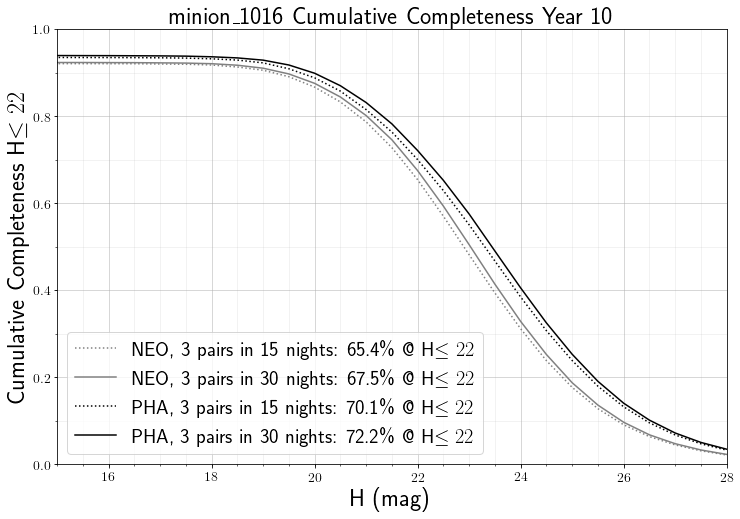

In [128]:
opsim = 'minion_1016'
strategy = ['3 pairs in 15 nights', '3 pairs in 30 nights']
Hidx = np.where(Hrange == 22)[0]
plt.figure(figsize=(12, 8))
for t in ('neo', 'pha'):
    for strat in strategy:
        comp = compTime(timebundles[opsim][t][strat].metricValues, Hrange2, times)
        if strat == '3 pairs in 15 nights':
            linestyle = ':'
        else:
            linestyle = '-'
        if t == 'neo': 
            color = 'gray'
        else:
            color = 'k'
        plt.plot(Hrange2, comp[-1], linestyle=linestyle, color=color, 
                 label=r'%s, %s: %.1f%s @ H$\le22$' % (t.upper(), strat, (comp[-1][Hidx]*100), '\%'))
plt.xlim(15, 28)
plt.ylim(0, 1)
xticks = np.arange(15, 28, 0.5)
ax = plt.gca()
ax.set_xticks(xticks, minor=True)
yticks = np.arange(0, 1, 0.1)
ax.set_yticks(yticks, minor=True)
ax.grid(which='minor', alpha=0.2)                                                
ax.grid(which='major', alpha=0.5)  
plt.legend(loc='lower left', fontsize='x-large', numpoints=1)
plt.xlabel(r'H (mag)', fontsize='xx-large')
plt.ylabel(r'Cumulative Completeness H$\le22$', fontsize='xx-large')
plt.title(r'minion\_1016 Cumulative Completeness Year 10', fontsize='xx-large')
plt.savefig('minion_1016_CumulativeCompleteness_NEO_and_PHA_Cumulative_Completeness.pdf', format='pdf')

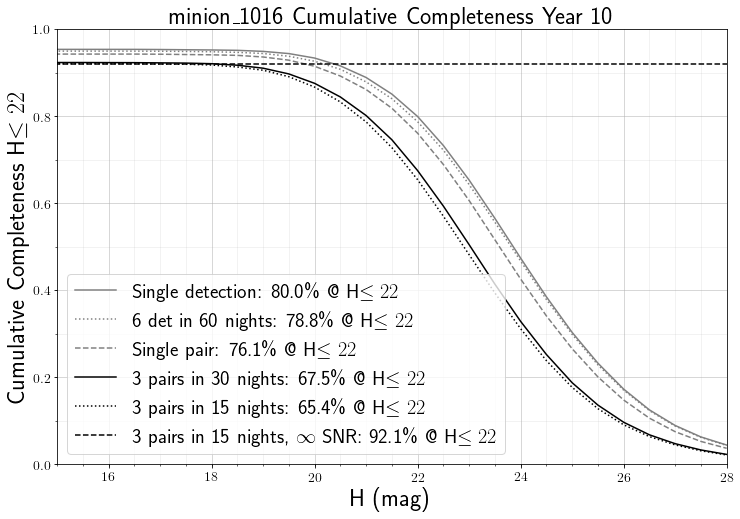

In [130]:
opsim = 'minion_1016'
Hidx = np.where(Hrange == 22)[0]
plt.figure(figsize=(12, 8))
for t in (['neo']):
    strat = 'Single detection'
    comp = compTime(timebundles[opsim][t][strat].metricValues, Hrange2, times)
    compval = comp[-1][Hidx]*100
    plt.plot(Hrange2, comp[-1], color='gray', linestyle='-', 
             label=r'%s: %.1f%s @ H$\le22$' % (strat, compval, '\%'))
    strat = '6 detections in 60 nights yr 10'
    m = metrics.MoCompletenessMetric(cumulative=True, Hindex=0.33)
    timebundles[opsim][t][strat].setSummaryMetrics([m])
    timebundles[opsim][t][strat].computeSummaryStats()
    comp = timebundles[opsim][t][strat].summaryValues['CumulativeCompleteness']['value']
    compval = comp[Hidx]*100
    plt.plot(Hrange2, comp, color='gray', linestyle=':',
             label=r'%s: %.1f%s @ H$\le22$' % ('6 det in 60 nights', compval, '\%'))
    strat = 'Single pair'
    comp = compTime(timebundles[opsim][t][strat].metricValues, Hrange2, times)
    compval = comp[-1][Hidx]*100
    plt.plot(Hrange2, comp[-1], color='gray', linestyle='--', 
             label=r'%s: %.1f%s @ H$\le22$' % (strat, compval, '\%'))
    strat = '3 pairs in 30 nights'
    comp = compTime(timebundles[opsim][t][strat].metricValues, Hrange2, times)
    compval = comp[-1][Hidx]*100
    plt.plot(Hrange2, comp[-1], color='k', linestyle='-', 
             label=r'%s: %.1f%s @ H$\le22$' % (strat, compval, '\%'))
    strat = '3 pairs in 15 nights'
    comp = compTime(timebundles[opsim][t][strat].metricValues, Hrange2, times)
    compval = comp[-1][Hidx]*100
    plt.plot(Hrange2, comp[-1], color='k', linestyle=':', 
             label=r'%s: %.1f%s @ H$\le22$' % (strat, compval, '\%'))
    strat = '3 pairs in 15 nights SNReq0'
    comp = compTime(timebundles[opsim][t][strat].metricValues, Hrange2, times)
    compval = comp[-1][Hidx]*100
    plt.plot(Hrange2, comp[-1], color='k', linestyle='--', 
             label=r'%s: %.1f%s @ H$\le22$' % ('3 pairs in 15 nights, $\infty$ SNR', compval, '\%'))
plt.xlim(15, 28)
plt.ylim(0, 1)
xticks = np.arange(15, 28, 0.5)
ax = plt.gca()
ax.set_xticks(xticks, minor=True)
yticks = np.arange(0, 1, 0.1)
ax.set_yticks(yticks, minor=True)
ax.grid(which='minor', alpha=0.2)                                                
ax.grid(which='major', alpha=0.5)  
plt.legend(loc='lower left', fontsize='x-large', numpoints=1)
plt.xlabel(r'H (mag)', fontsize='xx-large')
plt.ylabel(r'Cumulative Completeness H$\le22$', fontsize='xx-large')
plt.title(r'minion\_1016 Cumulative Completeness Year 10', fontsize='xx-large')
plt.savefig('minion_1016_neo_More_Cumulative_Completeness.pdf', format='pdf')

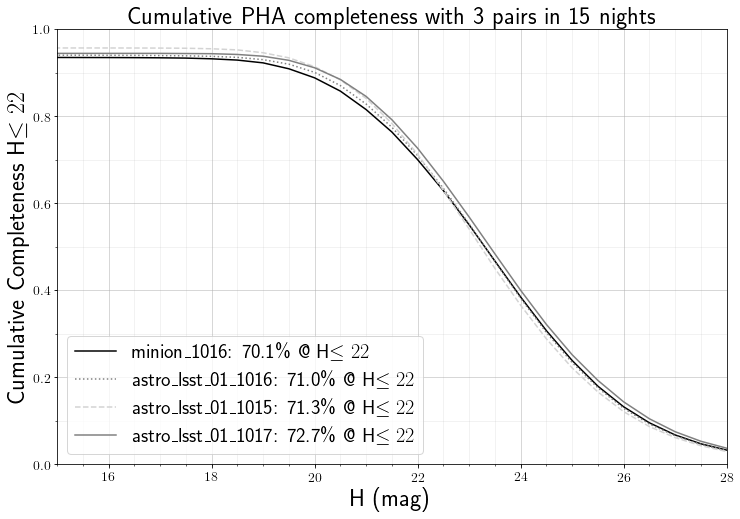

In [152]:
opsims = ['minion_1016', 'astro_lsst_01_1016', 'astro_lsst_01_1015', 'astro_lsst_01_1017']
plt.figure(figsize=(12, 8))
linestyle = ['-', ':', '--', '-']
color = ['k', 'gray', 'lightgray', 'gray']
times = np.array([59580, 59580+365*10])
for i, opsim in enumerate(opsims):
    t = 'pha'
    for strategy in (['3 pairs in 15 nights']):
        comp = compTime(timebundles[opsim][t][strategy].metricValues, Hrange2, times)
        plt.plot(Hrange2, comp[-1], linestyle=linestyle[i], color=color[i],
                 label=r'%s: %.1f%s @ H$\le22$' % (opsim.replace('_', '\_'), (comp[-1][Hidx]*100), '\%'))
plt.xlim(15, 28)
plt.ylim(0, 1)
xticks = np.arange(15, 28, 0.5)
ax = plt.gca()
ax.set_xticks(xticks, minor=True)
yticks = np.arange(0, 1, 0.1)
ax.set_yticks(yticks, minor=True)
ax.grid(which='minor', alpha=0.2)                                                
ax.grid(which='major', alpha=0.5)  
plt.legend(loc='lower left', fontsize='x-large', numpoints=1)
plt.xlabel(r'H (mag)', fontsize='xx-large')
plt.ylabel(r'Cumulative Completeness H$\le22$', fontsize='xx-large')
plt.title(r'Cumulative PHA completeness with 3 pairs in 15 nights', fontsize='xx-large')
plt.savefig('opsim_comparison_neo.pdf', format='pdf')